In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
orders = pd.read_csv('orders.csv')
users = pd.read_csv('users.csv')

---

# 3. 리텐션 분석
- 정리 링크 : https://velog.io/@suminwooo/%EC%BD%94%ED%98%B8%ED%8A%B8-%EB%B6%84%EC%84%9DCohort-Analysis

In [3]:
# 활용 대상자 추출
using_usr_lst = users[users['created_at']>'2024-01-01']['id'].tolist()

# 주문 테이블 정리
using_order_data = orders[
    (~orders['status'].isin(['Cancelled','Returned']))*
    (orders['user_id'].isin(using_usr_lst))
]
using_order_data['order_dt'] = [i[:7] for i in using_order_data['created_at']]
using_order_data = using_order_data[['user_id','order_dt']]

In [4]:
using_order_data.head()

,user_id,order_dt
3541,90,2024-05
3556,315,2024-03
3560,369,2024-05
3561,369,2024-01
3564,407,2024-04


In [5]:
# 첫 주문월 계산
first_order_data = using_order_data.groupby('user_id')[['order_dt']].min().reset_index()
first_order_data.columns = ['user_id','first_order_dt']

In [6]:
first_order_data.head()

,user_id,first_order_dt
0,12,2024-01
1,25,2024-04
2,90,2024-02
3,131,2024-08
4,136,2024-08


In [7]:
# 전체 주문내역과 첫주문 합쳐주기
merge_data = pd.merge(using_order_data, first_order_data, how='left', on='user_id')

In [8]:
merge_data.head()

,user_id,order_dt,first_order_dt
0,90,2024-05,2024-02
1,315,2024-03,2024-01
2,369,2024-05,2024-01
3,369,2024-01,2024-01
4,407,2024-04,2024-04


In [9]:
# 각각의 유저 수 구하기
cohorts = merge_data.groupby(['order_dt','first_order_dt'])[['user_id']].count().reset_index()
cohorts.columns = ['order_dt','first_order_dt','user_cnt']
cohorts = cohorts.sort_values(by=['first_order_dt','order_dt'])

In [10]:
# 기간별 레이블 붙이기 
each_period = cohorts["first_order_dt"].value_counts().sort_index()
cohortperiod = []

for x in each_period:
    for y in range(x):
        cohortperiod.append(y)

cohorts["order_dt"] = cohortperiod
cohorts = cohorts.set_index(["first_order_dt", "order_dt"])
cohorts = cohorts["user_cnt"].unstack(1)
cohorts.head()

order_dt,0,1,2,3,4,5,6,7
first_order_dt,,,,,,,,
2024-01,439.0,22.0,20.0,14.0,21.0,21.0,14.0,4.0
2024-02,420.0,20.0,19.0,24.0,15.0,20.0,10.0,NaN
2024-03,391.0,20.0,12.0,18.0,20.0,12.0,NaN,NaN
2024-04,443.0,34.0,23.0,32.0,16.0,NaN,NaN,NaN
2024-05,525.0,41.0,38.0,15.0,NaN,NaN,NaN,NaN


In [11]:
# 비율로 표현 해주기
user_retention = cohorts.divide(cohorts[0], axis=0)
user_retention

order_dt,0,1,2,3,4,5,6,7
first_order_dt,,,,,,,,
2024-01,1.0,0.050114,0.045558,0.031891,0.047836,0.047836,0.031891,0.009112
2024-02,1.0,0.047619,0.045238,0.057143,0.035714,0.047619,0.023810,NaN
2024-03,1.0,0.051151,0.030691,0.046036,0.051151,0.030691,NaN,NaN
2024-04,1.0,0.076749,0.051919,0.072235,0.036117,NaN,NaN,NaN
2024-05,1.0,0.078095,0.072381,0.028571,NaN,NaN,NaN,NaN
2024-06,1.0,0.097928,0.039548,NaN,NaN,NaN,NaN,NaN
2024-07,1.0,0.069193,NaN,NaN,NaN,NaN,NaN,NaN
2024-08,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


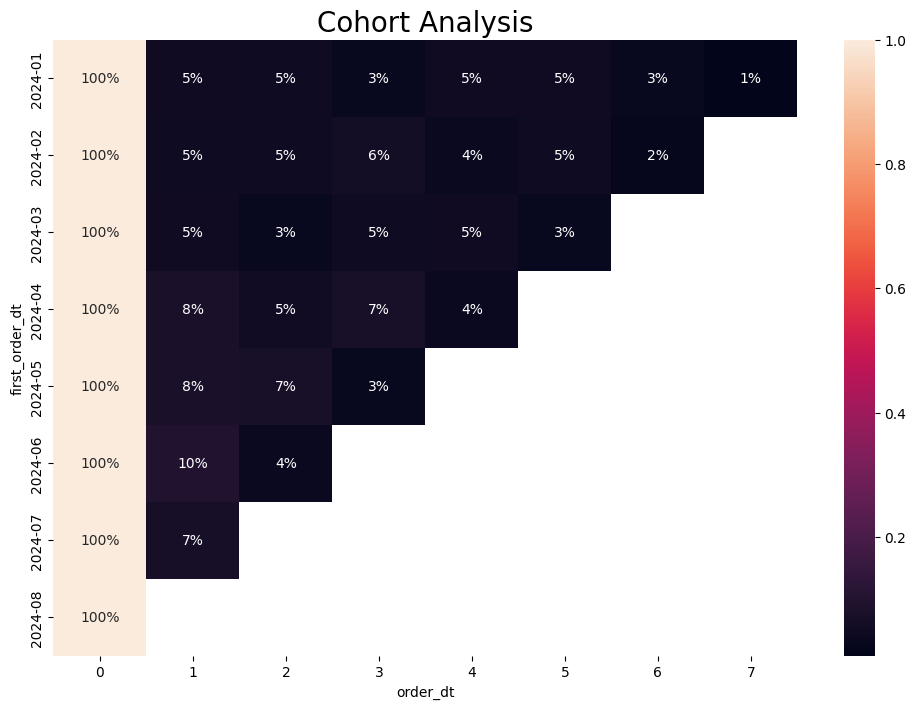

In [12]:
# 시각화
plt.figure(figsize=(12, 8))
plt.title("Cohort Analysis", fontsize=20)
sns.heatmap(user_retention, annot=True, fmt=".0%")
plt.show()